In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.serialization
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math

import biojepa_ac_model as model
from biojepa_ac_model import BioJepaConfig
from bio_dataloader import TrainingLoader

## BioJEPA Model load

In [2]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [3]:
torch.manual_seed(1337)
random.seed(1337)

In [4]:
batch_size = 32
n_embd = 8
training_file_chunk = 25000
n_heads = 2
n_layers = 2
n_genes = 5000

In [5]:
data_dir = Path('/Users/djemec/data/jepa/v0_2')
train_dir = data_dir / 'training'
checkpoint_dir = Path('/Users/djemec/data/jepa/v0_3') / 'checkpoints'
pert_dir = data_dir / 'pert_embd'
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'

In [6]:
print('Loading Action Embedding ...')
pert_embd = np.load(pert_embd_path)
print(f'Bank Loaded. Shape: {pert_embd.shape}')

Loading Action Embedding ...
Bank Loaded. Shape: (1087, 320)


In [7]:
#torch.set_float32_matmul_precision('high')
config = model.BioJepaConfig(
    num_genes = n_genes,
    n_layer= n_layers,
    heads= n_heads,
    embed_dim = n_embd,
    n_pre_layer= n_layers
)
model = model.BioJepa(config, pert_embd=pert_embd).to(DEVICE)

**Load Checkpoint**

In [8]:
checkpoint_path = checkpoint_dir / 'bio_jepa_pt_ckpt_35109_final.pt'
with torch.serialization.safe_globals([BioJepaConfig]):
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

**Freeze Model**

In [9]:
model.freeze_encoders()
model.eval()
for param in model.parameters():
    param.requires_grad = False

## Build Decoder

In [10]:
def init_weights_robust(module):
    if isinstance(module, (nn.Linear, nn.Embedding)):
        if isinstance(module, nn.Embedding):
            fan_in = module.embedding_dim
        else:
            fan_in = module.weight.size(1)
        std = 1.0 / math.sqrt(fan_in) if fan_in > 0 else 0.02
        nn.init.trunc_normal_(module.weight, mean=0.0, std=std, a=-2*std, b=2*std)
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)

@dataclass
class BenchmarkDecoderConfig:
    embed_dim: int = 256
    
class BenchmarkDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.head = nn.Linear(config.embed_dim, 1)

        self.apply(init_weights_robust)
        
    def forward(self, latents):

        gene_preds = self.head(latents)        
        gene_preds = gene_preds.squeeze(-1)
        
        return gene_preds

### Data Loader

In [11]:
train_loader = TrainingLoader(batch_size=batch_size, split='train', data_dir=train_dir, device=DEVICE)
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)

found 5 shards for split train
loading /Users/djemec/data/jepa/v0_2/training/train/shard_k562e_train_0001.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/v0_2/training/val/shard_k562e_val_0000.npz


## Training Decoder

### Training Config/Setup

In [12]:
lr_decoder = 1e-3
epochs = 5

**Initialize Decoder** 

In [13]:
config = BenchmarkDecoderConfig(
    embed_dim= n_embd
)

decoder = BenchmarkDecoder(config).to(DEVICE)

**Optimizer**

In [14]:
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr_decoder)

**Training Lenght**

In [15]:
train_total_examples = 101682
val_total_examples = 11044
test_total_examples = 38829

In [16]:
steps_per_epoch = train_total_examples // batch_size
max_steps = epochs * steps_per_epoch
steps_per_epoch, max_steps

(3177, 15885)

**Scheduler**

In [17]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr_decoder, total_steps=max_steps, pct_start=0.05
)

### Training Loop

In [18]:
lossi = []
step = 0
total_epoch_loss = 0

In [19]:
decoder.train()

for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 25
            for i in range(val_loss_steps):
                cont_x, cont_tot, case_x, case_tot, act_id = val_loader.next_batch()
                B, N = cont_x.shape

                # run BioJEPA
                z_context = model.student(cont_x, cont_tot, mask_idx=None)
                target_indices = torch.arange(N, device=DEVICE).expand(B, N)
                z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)

                # run new decoder
                pred_delta = decoder(z_pred_mu) - decoder(z_context)
                real_delta = case_x - cont_x

                loss = F.mse_loss(pred_delta, real_delta)
                val_loss_accum += loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')

        decoder.train()

    # periodically save checkpoint
    if step > 0 and  (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}.pt')

    # actual training

    cont_x, cont_tot, case_x, case_tot, act_id = train_loader.next_batch()
    B, N = cont_x.shape

    # run frozen BioJEPA
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)

    optimizer.zero_grad()

    # run decoder
    pred_case = decoder(z_pred_mu)
    pred_control = decoder(z_context)

    pred_delta = pred_case - pred_control
    real_delta = case_x - cont_x

    # loss
    loss = F.mse_loss(pred_delta, real_delta)
    loss.backward()

    optimizer.step()
    scheduler.step()

    # loss caching
    lossi.append(loss.item())
    total_epoch_loss += loss.item()

    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}_final.pt')
        

val loss: 3.0262
Step 0 | Loss: 3.12702 | LR: 4.00e-05
Step 25 | Loss: 3.03995 | LR: 4.25e-05
Step 50 | Loss: 3.04280 | LR: 4.98e-05
Step 75 | Loss: 2.93484 | LR: 6.16e-05
val loss: 2.9403
Step 100 | Loss: 2.97939 | LR: 7.79e-05
Step 125 | Loss: 2.91448 | LR: 9.85e-05
Step 150 | Loss: 2.88257 | LR: 1.23e-04
Step 175 | Loss: 2.83165 | LR: 1.52e-04
val loss: 2.7601
Step 200 | Loss: 2.83136 | LR: 1.84e-04
Step 225 | Loss: 2.70943 | LR: 2.20e-04
Step 250 | Loss: 2.60817 | LR: 2.58e-04
Step 275 | Loss: 2.59494 | LR: 2.99e-04
val loss: 2.4845
Step 300 | Loss: 2.43082 | LR: 3.43e-04
Step 325 | Loss: 2.40506 | LR: 3.87e-04
Step 350 | Loss: 2.34265 | LR: 4.34e-04
Step 375 | Loss: 2.28795 | LR: 4.81e-04
val loss: 2.1702
Step 400 | Loss: 2.20529 | LR: 5.28e-04
Step 425 | Loss: 2.10958 | LR: 5.76e-04
Step 450 | Loss: 2.07688 | LR: 6.23e-04
Step 475 | Loss: 1.90622 | LR: 6.68e-04
val loss: 1.8282
Step 500 | Loss: 1.83150 | LR: 7.13e-04
Step 525 | Loss: 1.76296 | LR: 7.55e-04
Step 550 | Loss: 1.6317

**Training Loss Plot**

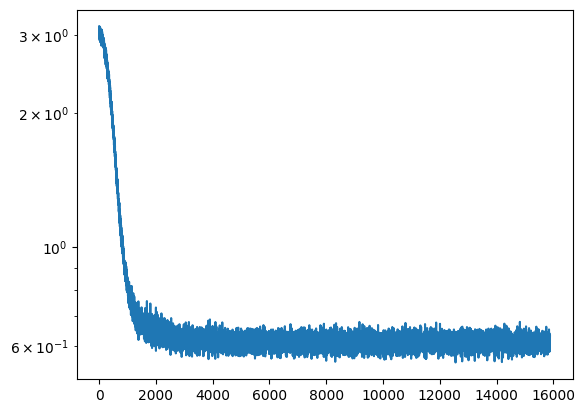

In [20]:
plt.plot(lossi)
plt.yscale('log')

## Trained Decoder Validation

In [21]:
import warnings
from scipy.stats import ConstantInputWarning

In [22]:
model.eval()
decoder.eval()

correlations = []
mses = []

In [23]:
val_steps_per_epoch = val_total_examples // batch_size
test_steps_per_epoch = test_total_examples // batch_size

In [25]:
for step in tqdm(range(val_steps_per_epoch), desc="Benchmarking"):
    
    # Custom Loader Call
    cont_x, cont_tot, case_x, case_tot, act_id = val_loader.next_batch()
    B, N = cont_x.shape
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)
        
        pred_delta = decoder(z_pred_mu) - decoder(z_context)
        real_delta = case_x - cont_x
    
    pred_np = pred_delta.cpu().numpy()
    real_np = real_delta.cpu().numpy()

    # Per-Sample Metrics
    for i in range(B):
        p = pred_np[i]
        t = real_np[i]
        mses.append(np.mean((p - t)**2))

        top_20_idx = np.argsort(np.abs(t))[-20:]

        p_top = p[top_20_idx]
        t_top = t[top_20_idx]
        
        if np.std(p_top) > 1e-9 and np.std(t_top) > 1e-9:
            corr, _ = pearsonr(p_top, t_top)
            if not np.isnan(corr):
                correlations.append(corr)
            else:
                correlations.append(0.0)
        else:
            correlations.append(0.0)

Benchmarking:  41%|████████████████████████                                   | 141/345 [00:23<00:34,  5.85it/s]

loading /Users/djemec/data/jepa/v0_2/training/val/shard_k562e_val_0000.npz


Benchmarking: 100%|███████████████████████████████████████████████████████████| 345/345 [00:58<00:00,  5.87it/s]


In [26]:
mean_mse = np.mean(mses)
mean_corr = np.mean(correlations) 
print(f'Global MSE: {mean_mse:.4f}')
print(f'Top-20 Pearson R: {mean_corr:.4f}')

Global MSE: 0.6096
Top-20 Pearson R: 0.9332


In [27]:
if mean_corr > 0.75:
    print('🌟 SOTA COMPETITIVE (Matches GEARS)')
elif mean_corr > 0.40:
    print('✅ FUNCTIONAL (Better than random)')
else:
    print('❌ NEEDS IMPROVEMENT')


🌟 SOTA COMPETITIVE (Matches GEARS)


## Trained Decoder Evaluation

In [28]:
eval_correlations = []
eval_mses = []

In [29]:
test_loader = TrainingLoader(batch_size=batch_size, split='test', data_dir=train_dir, device=DEVICE)
test_steps_per_epoch = test_total_examples // batch_size


found 2 shards for split test
loading /Users/djemec/data/jepa/v0_2/training/test/shard_k562e_test_0000.npz


In [30]:
for step in tqdm(range(test_steps_per_epoch), desc="Benchmarking"):
    
    # Custom Loader Call
    cont_x, cont_tot, case_x, case_tot, act_id = test_loader.next_batch()
    B, N = cont_x.shape
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, act_id, target_indices)
        
        pred_delta = decoder(z_pred_mu) - decoder(z_context)
        real_delta = case_x - cont_x
    
    pred_np = pred_delta.cpu().numpy()
    real_np = real_delta.cpu().numpy()

    # Per-Sample Metrics
    for i in range(B):
        p = pred_np[i]
        t = real_np[i]
        eval_mses.append(np.mean((p - t)**2))

        top_20_idx = np.argsort(np.abs(t))[-20:]

        p_top = p[top_20_idx]
        t_top = t[top_20_idx]
        
        if np.std(p_top) > 1e-9 and np.std(t_top) > 1e-9:
            corr, _ = pearsonr(p_top, t_top)
            if not np.isnan(corr):
                eval_correlations.append(corr)
            else:
                eval_correlations.append(0.0)
        else:
            eval_correlations.append(0.0)

Benchmarking:  64%|█████████████████████████████████████▎                    | 781/1213 [02:12<01:13,  5.89it/s]

loading /Users/djemec/data/jepa/v0_2/training/test/shard_k562e_test_0001.npz


Benchmarking: 100%|█████████████████████████████████████████████████████████| 1213/1213 [03:26<00:00,  5.87it/s]


In [31]:
eval_mean_mse = np.mean(eval_mses)
eval_mean_corr = np.mean(eval_correlations)
print(f'Global MSE: {eval_mean_mse:.4f}')
print(f'Top-20 Pearson R: {eval_mean_corr:.4f}')

Global MSE: 0.6059
Top-20 Pearson R: 0.9341


In [32]:
if eval_mean_corr > 0.75:
    print('🌟 SOTA COMPETITIVE (Matches GEARS)')
elif eval_mean_corr > 0.40:
    print('✅ FUNCTIONAL (Better than random)')
else:
    print('❌ NEEDS IMPROVEMENT')


🌟 SOTA COMPETITIVE (Matches GEARS)
